In [1]:
%%capture

!pip install -r requirements.txt -U

In [2]:
# Install and import necessary packages

import os
import math
import scipy
import cmath
import functools

import numpy as np
import control as ct
import itertools as it
import matplotlib.pyplot as plt

from mpmath import mp
from multiprocess import Pool
from tqdm.notebook import tqdm

In [164]:
def simplify(H: ct.TransferFunction):
    """ Takes a SISO transfer function `H` and cancels common factors in the numerator 
    and denominator. """

    fact = map(lambda x: np.flip(np.squeeze(x)), ct.tfdata(H))
    fact = list(it.zip_longest(*fact, fillvalue=0))

    for n, d in fact:
        if n == 0 and d == 0:
            fact.pop()
        else:
            break

    num, den = map(lambda x: np.flip(np.array(x, dtype=np.double)), zip(*fact))

    num /= den[-1]
    den /= den[-1]

    return ct.tf(num, den)

def plot(H: ct.TransferFunction, fq_start: float, fq_end: float, H_prop=1e-12):
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs. 
    frequency as well as oscillation frequency, and loop gain vs. duty cycle. """

    mp.dps = 40
    fig, (ax_osc, ax_ph) = plt.subplots(2)

    fq_start_exp = math.floor(math.log10(fq_start))
    fq_end_exp = math.ceil(math.log10(fq_end))
                           
    omega = np.logspace(fq_start_exp, fq_end_exp, num=100)

    def infsum(func, n_start, *args, **kwargs):
        return lambda f: mp.nsum(
            functools.partial(func, f, *args, **kwargs), 
            [n_start, mp.inf]
        )
            
    def phase(f, h, n):
        return (H(2j * cmath.pi * f * n) *
                cmath.exp(-H_prop * 2j * cmath.pi * f) *
                (1 - cmath.exp(-2j * cmath.pi * n * h)) *
                (1 - cmath.exp(2j * cmath.pi * n * h)) /
                (2 * n))

    ph_hs = np.linspace(0.05, 0.95, num=11)

    oscs = []

    for h in ph_hs[:len(ph_hs) // 2 + 1]:

        print(f"Calculating frequency response at {round(h * 100)}% duty cycle...")
        
        def calc_phase_fr(xs):
            with Pool(os.cpu_count()) as p:
                return np.degrees(np.unwrap(
                    np.vectorize(cmath.phase)(
                        np.fromiter(
                            p.map(infsum(phase, 1, h), xs), 
                            dtype=np.cdouble
                        )
                    )
                ))
            
        res = calc_phase_fr(omega)

        idx = np.argmin(abs(res + 180))
        idx_min = idx - 1 if idx else 0
        idx_max = idx + 1 if idx + 1 < (l := len(omega)) else l - 1

        omega_fine = np.linspace(omega[idx_min], omega[idx_max], num=100)

        res_fine = calc_phase_fr(omega_fine)

        oscs.append(omega_fine[np.argmin(abs(res_fine + 180))])

        data = list(zip(omega, res))
        data_fine = list(zip(omega_fine, res_fine))
        
        ax_ph.plot(*zip(*(data[:idx_min] + data_fine + data[idx_max + 1:])))
        ax_ph.set_xscale('log')
            
    osc_spline = scipy.interpolate.make_smoothing_spline(ph_hs, oscs + oscs[-2::-1])

    ax_osc.plot(xs := np.linspace(0.05, 0.95, num=50), [osc_spline(x) for x in xs])

    plt.show()


## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

In [4]:
def lpf(L, C, R_load) -> ct.TransferFunction:
    s = ct.tf('s')
    
    return R_load / (R_load * L * C * s**2 + L * s + R_load)

def fbn_example(R_in, C_in, R_lead, C_lead, R_fb, R_sep) -> ct.TransferFunction:
    s = ct.tf('s')

    b = R_lead + 1 / (C_lead * s)

    a = b + R_sep

    H_n = R_in * (a + R_fb) / (R_fb * a + R_in * a + R_fb *  R_in * a * C_in * s + R_fb * R_in)
    
    H = (R_sep + H_n * b) / (R_sep + b)

    return H

def fbn2(R_in, R_fb, R_lead, C_lead, C_int, R1_int, R2_int, R_int) -> ct.TransferFunction:
    s = ct.tf('s')
    
    a = R1_int * R2_int * C_int * R_int * C_lead  * (R_in + R_fb)
    b = R2_int * ((R1_int * C_int * R_in * R_lead) + (R_in * R_int * C_lead) + (R_fb * R_int * C_lead))
    bd = R2_int * R1_int * C_int * R_lead * R_fb
    ca = (R1_int + R2_int) * R_in * R_lead
    cb = (R_in + R_fb) * R2_int * R_lead

    return (a * s**2 + b * s + ca)/(a * s**2 + (b + bd) * s + cb)
    

Calculating frequency response at 10% duty cycle...
Calculating frequency response at 20% duty cycle...
Calculating frequency response at 30% duty cycle...
Calculating frequency response at 50% duty cycle...


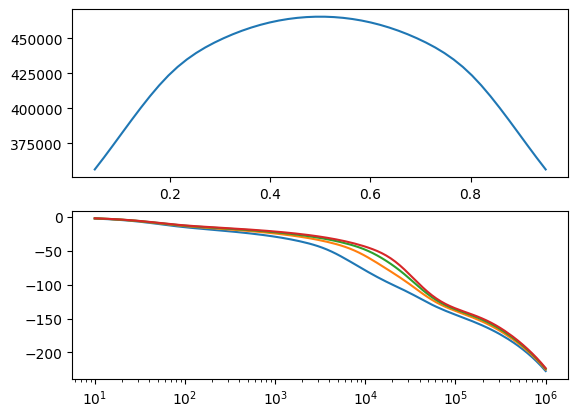

In [165]:
plot(lpf(30e-6, 680e-9, 4) * 
     fbn_example(1.8e3, 2.2e-9, 1e3, 330e-12, 8.2e3, 680),
     10, 600e3, H_prop=160e-9)